=== Dataset Overview ===
Total games simulated: 5,000
Unique strategy pairs: 10

First 5 rows:
  Player1_Strategy Player2_Strategy  Player1_Score  Player2_Score   Winner  \
0           Random           Random             24             24     Draw   
1           Random           Random             25             23  Player1   
2           Random           Random             19             29  Player2   
3           Random           Random             17             31  Player2   
4           Random           Random             41              7  Player1   

   Moves  Time_Seconds  
0     31         0.001  
1     38         0.001  
2     38         0.001  
3     45         0.001  
4     14         0.000  

=== Basic Statistics ===
Average scores:
       Player1_Score  Player2_Score
count    5000.000000    5000.000000
mean       20.543200      27.456800
std         8.017892       8.017892
min         3.000000       5.000000
25%        15.000000      23.000000
50%        19.000000      29

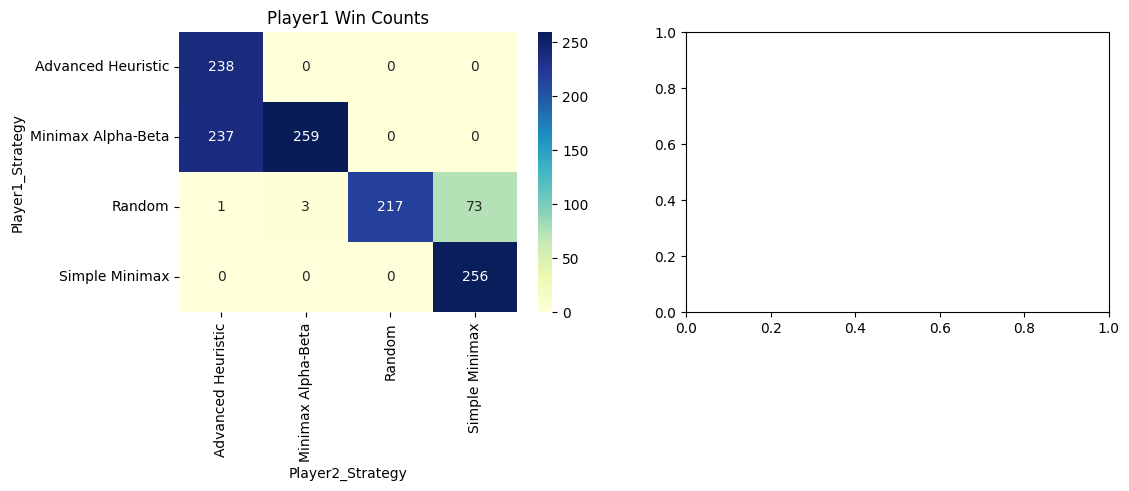

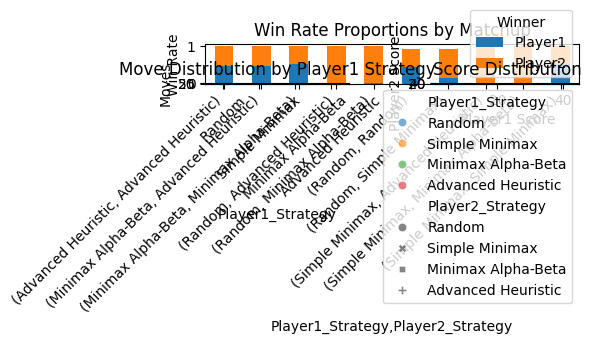


=== Advanced Metrics ===

Matchup Statistics:
                                       Avg_Score_Diff  Moves  Time_Seconds  \
Player1_Strategy   Player2_Strategy                                          
Advanced Heuristic Advanced Heuristic          -0.768   52.0     26.849496   
Minimax Alpha-Beta Advanced Heuristic           3.700   41.0      2.628126   
                   Minimax Alpha-Beta           0.432   37.0      0.300648   
Random             Advanced Heuristic         -13.712   35.0      2.289502   
                   Minimax Alpha-Beta         -17.200   31.0      0.166078   
                   Random                      -0.912   41.0      0.000908   
                   Simple Minimax             -10.424   36.5      0.730190   
Simple Minimax     Advanced Heuristic         -11.840   35.0     26.649380   
                   Minimax Alpha-Beta         -18.700   28.0      0.539964   
                   Simple Minimax               0.288   35.0      1.724124   

                

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(csv_path):
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Basic info
    print("=== Dataset Overview ===")
    print(f"Total games simulated: {len(df):,}")
    print(f"Unique strategy pairs: {df[['Player1_Strategy', 'Player2_Strategy']].drop_duplicates().shape[0]}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Basic statistics
    print("\n=== Basic Statistics ===")
    print("Average scores:")
    print(df[['Player1_Score', 'Player2_Score']].describe())
    
    print("\nGame duration stats:")
    print(df[['Moves', 'Time_Seconds']].describe())
    
    # Win rate analysis
    print("\n=== Win Rate Analysis ===")
    
    # Overall win rates
    overall_win_rates = df['Winner'].value_counts(normalize=True)
    print(f"\nOverall Win Rates:\n{overall_win_rates}")
    
    # Win rates by strategy pair
    strategy_win_rates = df.groupby(['Player1_Strategy', 'Player2_Strategy'])['Winner'] \
                         .value_counts(normalize=True) \
                         .unstack() \
                         .fillna(0)
    
    print("\nWin Rates by Strategy Matchup:")
    print(strategy_win_rates)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # Heatmap of Player1 win rates
    print("\nGenerating visualizations...")
    heatmap_data = df[df['Winner'] == 'Player1'].groupby(
        ['Player1_Strategy', 'Player2_Strategy']
    ).size().unstack().fillna(0)
    
    plt.subplot(2, 2, 1)
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu')
    plt.title('Player1 Win Counts')
    
    # Win rate comparison
    plt.subplot(2, 2, 2)
    strategy_win_rates[['Player1', 'Player2']].plot(kind='bar', stacked=True)
    plt.title('Win Rate Proportions by Matchup')
    plt.ylabel('Win Rate')
    plt.xticks(rotation=45, ha='right')
    
    # Move distribution
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Player1_Strategy', y='Moves', data=df)
    plt.title('Move Distribution by Player1 Strategy')
    plt.xticks(rotation=45)
    
    # Score comparison
    plt.subplot(2, 2, 4)
    sns.scatterplot(x='Player1_Score', y='Player2_Score', 
                    hue='Player1_Strategy', style='Player2_Strategy',
                    data=df, alpha=0.6)
    plt.title('Score Distribution')
    plt.xlabel('Player1 Score')
    plt.ylabel('Player2 Score')
    
    plt.tight_layout()
    plt.savefig('mancala_analysis.png')
    plt.show()
    
    # Advanced metrics
    print("\n=== Advanced Metrics ===")
    df['Score_Difference'] = df['Player1_Score'] - df['Player2_Score']
    
    matchup_stats = df.groupby(['Player1_Strategy', 'Player2_Strategy']).agg({
        'Score_Difference': 'mean',
        'Moves': 'median',
        'Time_Seconds': 'mean',
        'Winner': lambda x: (x == 'Player1').mean()
    }).rename(columns={
        'Score_Difference': 'Avg_Score_Diff',
        'Winner': 'Player1_Win_Rate'
    })
    
    print("\nMatchup Statistics:")
    print(matchup_stats)

if __name__ == "__main__":
    csv_file = "mancala_simulation_results_300.csv"
    analyze_results(csv_file)